This is a placeholder file aiming to remind us that:

Although there seems to be no big issue in the csv file,
it is important to preprocess the images even before the feature extraction!

I've found an interesting article:
https://medium.com/towards-data-science/medical-image-pre-processing-with-python-d07694852606

# Background Removal

Otsu's method is proven to be really effective:

https://amitprius.medium.com/opencv-adaptive-and-otsu-threshold-in-image-processing-with-python-648b64129876O

https://afetulhak.medium.com/crop-out-unwanted-border-pixels-from-medical-images-or-any-kind-of-image-b3def5dea2db

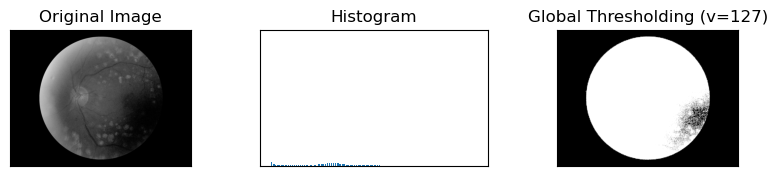

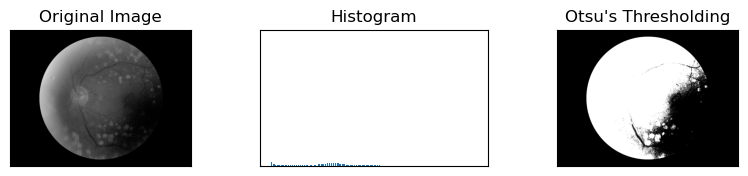

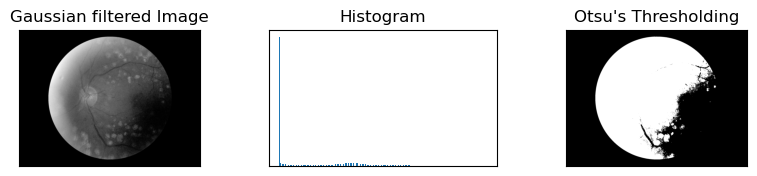

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt

image = cv.imread('images/2_left.jpg')
img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

 # threshold with the simple binary method
ret1,simp_thresh = cv.threshold(img,1,255,cv.THRESH_BINARY)

# Otsu's threshold without any filter
ret2,simp_thresh_otsu = cv.threshold(img, 0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Otsu's threshold using Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,otsu_filter = cv.threshold(blur,155,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# histogram of images
images = [img, 0, simp_thresh,
          img, 0, simp_thresh_otsu,
          blur, 0, otsu_filter]

titles = ['Original Image','Histogram','Global Thresholding (v=127)',
          'Original Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

# using a loop to visualize the different types of methods
for i in range(3):
    plt.figure(figsize=(10,6))
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])

plt.show()


In [2]:
from packages.small_batch_images import *
import numpy as np

It indeed removed the background effectively for our endoscopic images

# Image Cropping
following the otsu method, one can crop the image by selecting the bounding Rectangle
https://afetulhak.medium.com/crop-out-unwanted-border-pixels-from-medical-images-or-any-kind-of-image-b3def5dea2db

In [3]:
contours,hierarchy = cv.findContours(otsu_filter,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
cnts = sorted(contours, key=cv.contourArea, reverse=True)

x, y, w, h = cv.boundingRect(cnts[0])
crop = image[y:y+h, x:x+w]
cv.imwrite("test.jpg",crop)

True

# Proceed with all images

In [4]:
# Circle finder

In [6]:
image = cv.imread("images/59_left.jpg")

gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)
rows = gray.shape[0]
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, rows / 8,
                            param1=100, param2=30,
                            minRadius=int(min(image.shape[:2])*0.4), maxRadius=int(min(image.shape[:2])*0.55))
                            # minRadius=1000, maxRadius=1500)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv.circle(image, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv.circle(image, center, radius, (255, 0, 255), 3)


cv.imshow("detected circles", cv.resize(image, (512, int(512*image.shape[0]/image.shape[1]))))
cv.waitKey(0)


-1

In [7]:
int(min(image.shape[:2])*0.45)

583

In [8]:
image.shape

(1296, 1936, 3)

## Color correction and frontier removal
https://stackoverflow.com/questions/53417926/using-local-average-color-of-image-to-reduce-difference-in-lightning

In [9]:
def color_correct(image, kernel_size):
    blurred = cv.blur(image, ksize=(kernel_size, kernel_size))
    result = cv.addWeighted(image, 4, blurred, -4, 128)
    return result

In [21]:
def frontier_remove(image):
    h, w = image.shape[:2]
    diameter = int(h*0.87) #keep 87% content in a circle
    mask = np.zeros((image.shape), dtype=np.uint8)
    cv.circle(mask, (h//2, w//2), int(diameter/2), (255, 255, 255), -1)
    # put mask into alpha channel of input
    result = cv.cvtColor(image, cv.COLOR_BGR2BGRA)
    result[:, :, 3] = mask[:,:,0]
    result = cv.cvtColor(result, cv.COLOR_BGRA2BGR)
    # gray out other sections
    result[np.where(mask == 0)] = 128
    return result

## Equalization

In [11]:
def equalize(img):
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    H, S, V = cv.split(hsv_img)
    output_V = cv.equalizeHist(V)
    hsv_img = cv.merge((H, S, V))
    img = cv.cvtColor(hsv_img, cv.COLOR_HSV2BGR)
    return img

## Autocontrast
https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape

In [12]:
def autocontrast(img, clip_hist_percent=1):
    alpha = 1.95 # Contrast control (1.0-3.0)
    beta = 0 # Brightness control (0-100)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # gray image histogram
    hist = cv.calcHist([img_gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    img = cv.convertScaleAbs(img, alpha=alpha, beta=beta)
    return img


or z-score 
https://iovs.arvojournals.org/article.aspx?articleid=2791087

In [13]:
def z_score_norm(img):
    B, G, R = cv.split(img)
    for color in [B, G, R]:
        mean = color[color.nonzero()].mean()
        std = color[color.nonzero()].std()
        print(mean, std)
        color = (color - mean)/std
        print(color[color.nonzero()].mean())

    return cv.merge((B, G, color))

In [14]:
import matplotlib.pyplot as plt
image = cv.imread('images/595_right.jpg')
# fig, ax = plt.subplots(1, 2, figsize=(15, 20))
# ax[0].imshow(cv.cvtColor((image), cv.COLOR_BGR2RGB))
# ax[1].imshow(cv.cvtColor(z_score_norm(image), cv.COLOR_BGR2RGB))
# plt.show()

## Detail enhancement
https://link.springer.com/chapter/10.1007/978-3-030-32239-7_16

In [15]:
def sigmoid(d, alpha):
    import numpy as np
    return 2/(1+np.exp(-alpha*d/255))-1

In [16]:
def detail_enhance(img):
    lab_img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    L, A, B = cv.split(lab_img)
    j_1 = cv.edgePreservingFilter(L,  sigma_s=5, sigma_r=0.07)
    j_2 = cv.edgePreservingFilter(j_1, sigma_s=5, sigma_r=0.07)
    D_0 = L - j_1
    D_1 = j_1 - j_2
    L_enhanced = j_2 + sigmoid(D_0, 10).astype('uint8')*255 + sigmoid(D_1, 10).astype('uint8')*255*35
    L_enhanced = j_2 + D_0 + D_1
    plt.imshow(D_0)
    print(D_0.max())
    lab_img = cv.merge((L_enhanced, A, B))
    img = cv.cvtColor(lab_img, cv.COLOR_LAB2BGR)
    return img

## Preprocessing (combining all)

In [17]:
def crop_to_square_and_resize(img):
    h, w = img.shape[:2]
    square_size = min(img[:,:,0].shape)
    x = w//2 - square_size//2
    y = h//2 - square_size//2
    return cv.resize(img[y:y+square_size, x:x+square_size], (512, 512), interpolation = cv.INTER_LANCZOS4)

In [18]:
# Combine the necessary codes above
def preprocess(image):
    # normalize and equalize the image
    # image = cv.detailEnhance(image)
    # image = detail_enhance(image)
    pre = cv.normalize(image, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=-1)
    pre = equalize(pre)
    pre = autocontrast(pre)
    gray = cv.cvtColor(pre, cv.COLOR_BGR2GRAY)
    ret,simp_thresh = cv.threshold(gray,2,255,cv.THRESH_BINARY)
    # # Otsu's threshold using Gaussian filtering
    # blur = cv.GaussianBlur(gray,(5,5),0)
    # ret, otsu_filter = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    contours, hierarchy = cv.findContours(simp_thresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key=cv.contourArea, reverse=True)
    x, y, w, h = cv.boundingRect(cnts[0])
    crop = image[y:y+h, x:x+w]
    crop = color_correct(crop, kernel_size=int(len(image)/25))
    return crop

In [ ]:

cv.imshow("detected circles", cv.resize(preprocess(image), (512, int(512*image.shape[1]/image.shape[0]))))
cv.waitKey(0)

13

: 

In [23]:
import pandas as pd
import os

df = load_annotation()

# for i in range(100):
for i in range(len(df)):
    # script_dir is in the small_batch_images scirpt
    img_l = cv.imread(os.path.join(script_dir, "../images/{}").format(df.Left_Fundus.values[i]))
    img_l = preprocess(img_l)
    asp_ratio = img_l.shape[0]/img_l.shape[1]
    # drop the images which are cropeed too much
    if asp_ratio < 0.8 or asp_ratio>1.2:
        continue
    img_l = crop_to_square_and_resize(img_l)
    img_l = frontier_remove(img_l)
    cv.imwrite(os.path.join(script_dir, "../images_test/{}").format(df.Left_Fundus.values[i]), img_l)
    img_r = cv.imread(os.path.join(script_dir, "../images/{}").format(df.Right_Fundus.values[i]))
    img_r = preprocess(img_r)
    asp_ratio = img_r.shape[0]/img_r.shape[1]
    if asp_ratio < 0.8 or asp_ratio>1.2:
        continue
    img_r = crop_to_square_and_resize(img_r)
    img_r = frontier_remove(img_r)
    cv.imwrite(os.path.join(script_dir, "../images_test/{}").format(df.Right_Fundus.values[i]), img_r)

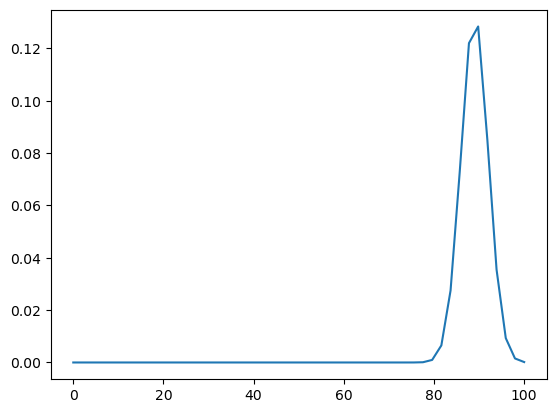

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
sig = 3
y_i = 89
k = np.linspace(0, 100)
y_tick = 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((k - y_i) / sig, 2.0) / 2)
plt.plot(k, y_tick)